# MNIST data setup

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)


In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


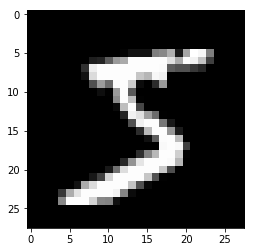

In [3]:
from matplotlib import pyplot
%matplotlib inline  
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)


In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# Neural net from scratch (no torch.nn)

## set requires_grad after the initialization

- initialization과정에서 gradient 계산하는 것을 원하지 않는다.
- 따라서 weight initialization 이후에, `requires_grad = True`로 변경한다.

In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

### Thanks to Pytorch autograd, can use any standard Python function (or callable object) as a model!
### Pytorch autograd 덕분에, 표준 python function 모두를 편하게 사용할 수 있다.

- `@`은 matrix multiplication이다.

In [6]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [7]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.9013, -2.5975, -2.4701, -2.1978, -2.1825, -2.4478, -2.5998, -2.1575,
        -1.8531, -2.0474], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [8]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [9]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3671, grad_fn=<NegBackward>)


In [10]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [11]:
print(accuracy(preds, yb))

tensor(0.0781)


## gradient update within `torch.no_grad()`

- weight와 bias를 업데이트할 때, `torch.no_grad()` 컨텍스트 관리자 안에서 수행한다.
- 그래야지 다음 gradient 계산시, 업데이트 내용을 반영하지 않는다.
<br/>

- 그래도, Iteration 초기에 gradient를 zero해주지 않으면, 메모리가 계속 증가하지 않나?
- 차라리 이럴꺼면 Iteration초기에 gradient를 zero해주는게 편하지 않나?
- Ipython.core.debugger 사용법 확인

In [12]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [13]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0824, grad_fn=<NegBackward>) tensor(1.)


# Using torch.nn.functional

- 위의 코드들을 `torch.nn`의 class들을 이용해서, 간편하고, 유연하게 만들어보자
    -  코드를 짧게/ 이해하기 쉽고/ 유연하게  
    
    
**변경사항**   
1. 각 기존 standard python 코드들을 `torch`에서 제공하는 함수를 사용하자.

In [14]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [15]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0824, grad_fn=<NllLossBackward>) tensor(1.)


# Refactor using nn.Module

- `nn.Module`, `nn.Parameter`를 이용해서, training loop를 조금 더 간편하게 만들어보자

**이점**

1. subclassing을 통해서 `forward`를 쉽게 할 수 있다.
2. `.parameters()`, `.zero_grad()` 메소드를 사용할 수 있다.  
     
<br/>
     
- `nn.Module`의 대문자 `M`는 **Pytorch**만의 특정 개념이고, Class를 의미한다.
- python의 소문자 `m`의 `module`과 혼동되면 안된다

In [16]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [17]:
model = Mnist_Logistic()

In [18]:
print(loss_func(model(xb), yb))

tensor(2.2063, grad_fn=<NllLossBackward>)


## before approach

```python
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

```

## present approach

- it more simple

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

In [19]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [20]:
print(loss_func(model(xb), yb))

tensor(0.0815, grad_fn=<NllLossBackward>)


# Refactor using nn.Linear

- 직접 weiths와 bias를 초기화하고, multiplication하던 것을 `nn.Linear`를 통해서 리팩토링

In [21]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [22]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2756, grad_fn=<NllLossBackward>)


In [23]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0808, grad_fn=<NllLossBackward>)


# Refactor using optim

- 이전에 SGD를 코드로 구현해놓은 것을 `torch.optim` 패키지를 이용해 리팩토링

## before

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

## now

```python
opt.step()
opt.zero_grad()
```

- `optim.zero_grad()`는 gradient들을 모두 초기화해준다.

In [24]:
from torch import optim

In [25]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3485, grad_fn=<NllLossBackward>)
tensor(0.0799, grad_fn=<NllLossBackward>)


# Refactor using Dataset

- pytorch의 abstract dataset class를 이용해서 리팩토링
- dataset class는 시퀸스

In [26]:
from torch.utils.data import TensorDataset

In [27]:
train_ds = TensorDataset(x_train, y_train)

In [28]:
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]

In [29]:
xb,yb = train_ds[i*bs : i*bs+bs]

In [30]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0815, grad_fn=<NllLossBackward>)


# Refactor using DataLoader

- dataloader는 batch를 다루는 매니저
- dataloader는 모든 dataset 클래스를 받을 수 있음
- `train_ds[i*bs : i*bs+bs]`형태보다는 dataloader를 사용하는게 더 현명함

## past

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)
```

## now
```python
for xb,yb in train_dl:
    pred = model(xb)

```

In [31]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [33]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0812, grad_fn=<NllLossBackward>)


# Add validation

- validation하는 방법에 대해서 확인해보자  

<br/>

- 학습 전 `model.train()`을 꼭 해줘야하며, 추론 시, `model.eval()`를 꼭 해줘야한다.
- 위에 대한 이유는, `nn.BatchNorm2d`, `nn.Dropout`의 적절한 동작을 보장해야하기 때문이다.ent phases 

In [34]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [35]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))


0 tensor(0.2892)
1 tensor(0.2992)


# Create fit() and get_data()

- train / valid에 대해 따로 적용하기 위한 리팩토링

In [36]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [37]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [38]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [39]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.3304295279979706
1 0.3042882658958435


# Switch to CNN



In [40]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [41]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.43612044582366943
1 0.23779212560653687


# nn.Sequential

In [42]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [43]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3297055669784546
1 0.29092803540229795


# Wrapping DataLoader

여태까지 만들어온 CNN의 data에는 2가지 조건이 있었음

- 28*28 long vector
- CNN grid size는 4*4

이 2가지 조건을 없애보자

또한 `nn.AvgPool2d`를 `nn.AdaptiveAvgPool2d`로 변경하게 되면,  
출력 텐서의 shape을 정해줄 수 있다.

따라서 input shape을 크게 신경쓰지 않아도 된다.

In [45]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [46]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


In [47]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.6321418508529663
1 0.5152196035385131


# Using your GPU

In [48]:
print(torch.cuda.is_available())

True


In [49]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [50]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [51]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [52]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.46312644839286804
1 0.4459692581653595


# Closing thoughts

We now have a general data pipeline and training loop which you can use for training many types of models using  
Pytorch. To see how simple training a model can now be, take a look at the mnist_sample sample notebook.  
    
Of course, there are many things you’ll want to add, such as data augmentation, hyperparameter tuning, monitoring  
training, transfer learning, and so forth. These features are available in the fastai library, which has been  
developed using the same design approach shown in this tutorial, providing a natural next step for practitioners  
looking to take their models further.  
    
We promised at the start of this tutorial we’d explain through example each of torch.nn, torch.optim, Dataset, and DataLoader. So let’s summarize what we’ve seen:  

- torch.nn
    - Module: creates a callable which behaves like a function, but can also contain state(such as neural net layer weights). It knows what Parameter (s) it contains and can zero all their gradients, loop through them for weight updates, etc.  
          
    - Parameter: a wrapper for a tensor that tells a Module that it has weights that need updating during backprop. Only tensors with the requires_grad attribute set are updated  
           
    - functional: a module(usually imported into the F namespace by convention) which contains activation functions, loss functions, etc, as well as non-stateful versions of layers such as convolutional and linear layers.  
          
- torch.optim: Contains optimizers such as SGD, which update the weights of Parameter during the backward step
    - Dataset: An abstract interface of objects with a __len__ and a __getitem__, including classes provided with Pytorch such as TensorDataset  
          
    - DataLoader: Takes any Dataset and creates an iterator which returns batches of data.